Tutorial: Lightweight optimisation using a gradient-based smeared approach
==
Date: 4 February 2026

Author: Saullo G. P. Castro

Cite this tutorial as:

Castro, SGP. Methods for analysis and design of composites (Version 0.8.4) [Computer software]. 2024. https://doi.org/10.5281/zenodo.2871782


Installing required modules
--

In [1]:
!python -m pip install numpy scipy > tmp.txt

DEPRECATION: Loading egg at /Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/panels-0.5.0-py3.13-macosx-11.1-arm64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/tuduam-2026.3-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


References
--

Riche, R. Le, and Haftka, R. T., 1993, “Optimization of Laminate Stacking Sequence for Buckling Load Maximization by Genetic Algorithm,” AIAA J., 31(5), pp. 951–956. https://arc.aiaa.org/doi/10.2514/3.11710


Laminate plate geometry and applied loading:
---

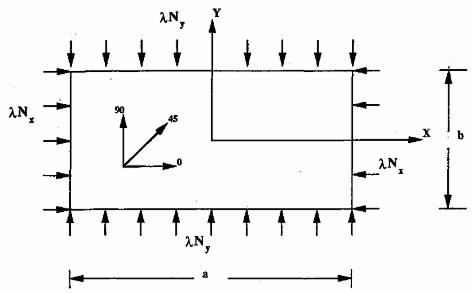

Constraint - Critical buckling load $\lambda_b$, calculated analytically with:
---

From Riche and Haftka's paper:

$$\frac{\lambda_b(m, n)}{\pi^2} = \frac{\left[D_{11} (m/a)^4 + 2 (D_{12} + 2 D_{66}) (m/a)^2 (n/b)^2 + D_{22} (n/b)^4\right]}{((m/a)^2 Nxx + (n/b)^2 Nyy)}\ (1)$$

Constraint - strain failure
---
This constraint requires that all strain components remain below an allowable limit, assuming that $\gamma_{xy}$ will be zero for this bi-axial loading, given that the laminate is balanced.


The principal strains on each layer can be calculated solving first the laminate bi-axial strains $\epsilon_x$ and $\epsilon_y$; and later the in-plane strains of each layer: $\epsilon_1^i$, $\epsilon_2^i$ and $\gamma_{12}^i$:

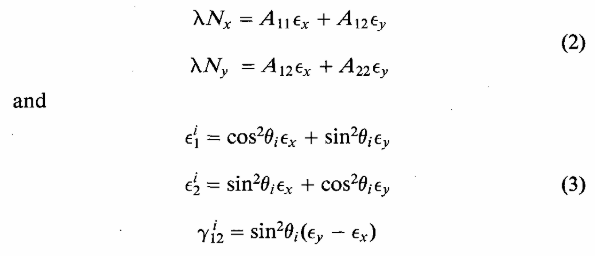

In [2]:
# NOTE allowable strains from the reference paper
epsilon_1_allowable = 0.008
epsilon_2_allowable = 0.029
gamma_12_allowable = 0.015

Optimization description
--

Take as reference the first design case of Table 3

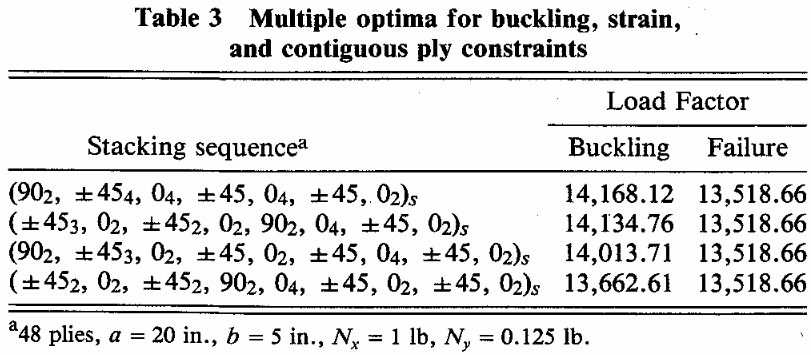


Note that the design is currently constrained by the failure index.


Note that the number of plies here has been pre-defined to 48 plies, and with the ghost layer approach, we will be able to remove plies.

We will set a target design load by means of a target lambda that will multiply the bi-axial loading state.

Defining the reference case
---

Using the first stacking sequence of the Table 3 above:


In [3]:
import numpy as np
# Table 03, first row
a_value = 20. # [in]
b_value = 5. # [in]
load_Nxx_unit = 1. # [lb]
load_Nyy_unit = 0.125 # [lb]
stack_ref_half = [90]*2 + [+45,-45]*4 + [0]*4 + [+45, -45] + [0]*4 + [+45, -45] + [0]*2 
stack_ref = stack_ref_half + stack_ref_half[::-1] # symmetry condition

assert len(stack_ref) == 48
num_variables = len(stack_ref) // 4 # NOTE independent angles for a symmetric and balanced laminate

# NOTE: make sure that you understand this
num_variables = 2*num_variables # NOTE twice as many variables needed for the ghost layer approach

# material properties
E11 = 127.55e9 # [Pa]
E22 = 13.03e9
nu12 = 0.3
G12 = 6.41e9
G13 = 6.41e9
G23 = 6.41e9
laminaprop = (E11, E22, nu12, G12, G13, G23)
ply_thickness = 0.005*25.4/1000 # [m]
h = ply_thickness*len(stack_ref)


In [4]:
def get_Q_matrix(theta_deg):
    """
    Calculate the transformed reduced stiffness matrix Q_bar for a given angle.
    """
    nu21 = nu12 * E22 / E11
    denom = 1 - nu12 * nu21
    Q11 = E11 / denom
    Q22 = E22 / denom
    Q12 = nu12 * E22 / denom
    Q66 = G12

    c = np.cos(np.radians(theta_deg))
    s = np.sin(np.radians(theta_deg))

    c2 = c**2; s2 = s**2; c4 = c**4; s4 = s**4

    Q_bar_11 = Q11*c4 + 2*(Q12 + 2*Q66)*s2*c2 + Q22*s4
    Q_bar_22 = Q11*s4 + 2*(Q12 + 2*Q66)*s2*c2 + Q22*c4
    Q_bar_12 = (Q11 + Q22 - 4*Q66)*s2*c2 + Q12*(s4 + c4)
    Q_bar_66 = (Q11 + Q22 - 2*Q12 - 2*Q66)*s2*c2 + Q66*(s4 + c4)

    Q_bar_44 = G23 * c2 + G13 * s2
    Q_bar_55 = G13 * c2 + G23 * s2
    Q_bar_45 = (G13 - G23) * c * s

    Q_bar = np.array([
        [Q_bar_11, Q_bar_12, 0, 0, 0, 0],
        [Q_bar_12, Q_bar_22, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, Q_bar_44, Q_bar_45, 0],
        [0, 0, 0, Q_bar_45, Q_bar_55, 0],
        [0, 0, 0, 0, 0, Q_bar_66]
    ])
    return Q_bar


In [5]:
class SmearedProp:
    def __init__(self, h0, h45, h90):
        # Pre-calculate Base Q matrices
        self.angles = [0, 45, 90]
        self.Q0 = get_Q_matrix(0)
        self.Q90 = get_Q_matrix(90)
        self.Q45p = get_Q_matrix(45)
        self.Q45m = get_Q_matrix(-45)
        self.Q45_sum = self.Q45p + self.Q45m
        self.h0 = h0
        self.h45 = h45
        self.h90 = h90
        h_total = h0 + 2*h45 + h90
        self.A = h0 * self.Q0 + h45 * self.Q45_sum + h90 * self.Q90
        self.D = (h_total**2 / 12.0) * self.A


Analytical equation to calculate buckling
---

In [6]:
from numpy import pi

def calc_buckling_analytical(prop):
    a = a_value*25.4/1000 # [m] along x
    b = b_value*25.4/1000 # [m] along y
    Nxx = load_Nxx_unit*4.448222/(25.4/1000) #[N/m]
    Nyy = load_Nyy_unit*4.448222/(25.4/1000) #[N/m]
    
    D11 = prop.D[0, 0]
    D12 = prop.D[0, 1]
    D22 = prop.D[1, 1]
    D66 = prop.D[5, 5]
    lambda_b_min = 1e30
    for m in range(1, 21):
        for n in range(1, 21):
            lambda_b = (pi**2*(D11*(m/a)**4
                             + 2*(D12 + 2*D66)*(m/a)**2*(n/b)**2
                             + D22*(n/b)**4)/((m/a)**2*Nxx + (n/b)**2*Nyy)
                       )
            lambda_b_min = min(lambda_b_min, lambda_b)
    return lambda_b_min   

Function to calculate strain failure criterion
---

In [7]:
import scipy.optimize as opt

def calc_failure_load_Haftka(prop):
    def strain_MS(lbd):
        Nxx = -load_Nxx_unit*4.448222/(25.4/1000) #[N/m]
        Nyy = -load_Nyy_unit*4.448222/(25.4/1000) #[N/m]
        Nxx = lbd*Nxx*1.5
        Nyy = lbd*Nyy*1.5
        vecN = np.asarray([Nxx, Nyy])
        A11 = prop.A[0, 0]
        A12 = prop.A[0, 1]
        A22 = prop.A[1, 1]
        exx, eyy = np.linalg.inv(np.array([[A11, A12], [A12, A22]])) @ vecN
        margin_of_safety = 1e15
        for thetadeg in prop.angles:
            cost = np.cos(np.deg2rad(thetadeg))
            sint = np.sin(np.deg2rad(thetadeg))
            epsilon_i_1 = cost**2*exx + sint**2*eyy
            epsilon_i_2 = sint**2*exx + cost**2*eyy
            gamma_i_12 = sint**2*(eyy - exx)
            ms_new = min(
                    epsilon_1_allowable/abs(epsilon_i_1) - 1,
                    epsilon_2_allowable/abs(epsilon_i_2) - 1,
                    gamma_12_allowable/abs(gamma_i_12) - 1
                    )
            margin_of_safety = min(margin_of_safety, ms_new)
        return margin_of_safety
    lbd_init = 100
    positiveMS = opt.NonlinearConstraint(strain_MS, 0., np.inf, jac='2-point')
    res = opt.minimize(strain_MS, lbd_init, tol=1e-6, bounds=((100, None),),
            constraints=[positiveMS], jac='2-point')
    assert res.success
    return res.x[0]


Verifying constraint functions
---
Compare with columns 2 and 3 of Table 3 below, first row.

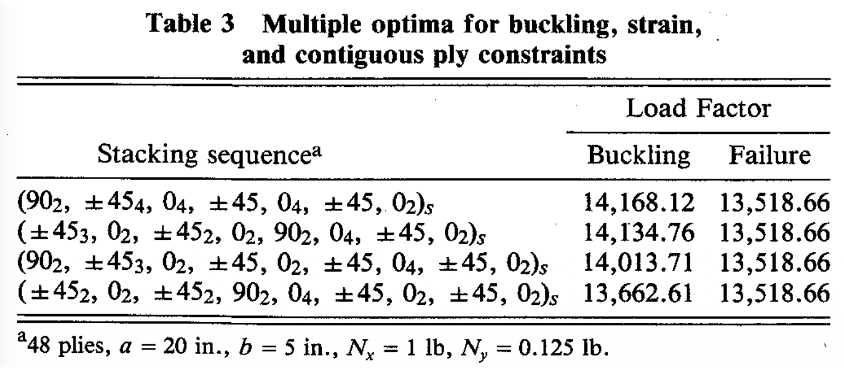

In [8]:
h0 = ply_thickness*np.sum(np.isclose(stack_ref, 0))
h45 = ply_thickness*np.sum(np.isclose(stack_ref, 45))
h90 = ply_thickness*np.sum(np.isclose(stack_ref, 90))
prop_ref = SmearedProp(*[h0, h45, h90])
    
lambda_cb_ref_analytical = calc_buckling_analytical(prop_ref)
print('lambda_cb_ref_analytical', lambda_cb_ref_analytical)

lambda_cs_ref = calc_failure_load_Haftka(prop_ref)
print('lambda_cs_ref', lambda_cs_ref)


lambda_cb_ref_analytical 12181.43642260919
lambda_cs_ref 13517.970921520922


/var/folders/x7/jww7lc053bv10s9m981_324dmy7lhy/T/ipykernel_23181/3154083915.py:24: RuntimeWarning: divide by zero encountered in divide
  gamma_12_allowable/abs(gamma_i_12) - 1


Defining design load
---

In [9]:
target_lambda = 10000

Defining objective function
---

In [10]:
#def objective_Workshop1(x): # NOTE to be minimized
#    stack = discrete_stack_from_continuous_x(x)
#    prop = laminated_plate(stack=stack, plyt=ply_thickness, laminaprop=laminaprop)
#    lambda_cb = calc_buckling_FE(prop)
#    lambda_cs = calc_failure_load_Haftka(prop)
#    p = 0.08 # NOTE from the reference paper
#    obj = (1 - p)*min(lambda_cs, lambda_cb)
#    return 1/obj

def volume(x): # NOTE to be minimized
    a = a_value*25.4/1000 # [m] along x
    b = b_value*25.4/1000 # [m] along y
    h_total = np.sum(x)
    return h_total*a*b # [m^3]



Defining constraint functions
---

In [11]:
def calc_constr_buckling(x): # NOTE feasible when >= 0
    prop = SmearedProp(*x)
    lambda_cb = calc_buckling_analytical(prop)
    return lambda_cb/target_lambda - 1

def calc_constr_failure(x): # NOTE feasible when >= 0
    prop = SmearedProp(*x)
    lambda_cs = calc_failure_load_Haftka(prop)
    return lambda_cs/target_lambda - 1

test = np.asarray(2*[2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
h0 = np.sum(test==0)*ply_thickness
h45 = np.sum(test==1)*ply_thickness
h90 = np.sum(test==2)*ply_thickness

prop = SmearedProp(*[h0, h45, h90])
lambda_cb = calc_buckling_analytical(prop)
print(lambda_cb)

80362.30809229247


Optimisation using SLSQP
---

Here we define the optimization problem:

In [12]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

n_var = 3
h_min = ply_thickness
h_max = 48*ply_thickness
x0 = np.ones(n_var) * (h_min + h_max) / 2.0
bounds = Bounds([h_min]*n_var, [h_max]*n_var)

# Inequality constraint: fun(x) >= 0
# We use a lambda to pass 'problem' into the function
constraints = [{'type': 'ineq', 'fun': calc_constr_buckling},
               {'type': 'ineq', 'fun': calc_constr_failure}]

print("Starting SLSQP Optimization with Scipy...")

res = minimize(
    volume,
    x0,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'ftol': 1e-6, 'disp': True, 'maxiter': 200},
    jac="2-point"
)

print("Best solution found: %s" % res.x)

Starting SLSQP Optimization with Scipy...


/var/folders/x7/jww7lc053bv10s9m981_324dmy7lhy/T/ipykernel_23181/3154083915.py:24: RuntimeWarning: divide by zero encountered in divide
  gamma_12_allowable/abs(gamma_i_12) - 1


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00023580657908711325
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 5
Best solution found: [0.00164833 0.00187968 0.000127  ]


Checking the optimization result:

In [13]:
prop_opt = SmearedProp(*res.x)
ms_buckling_opt = calc_buckling_analytical(prop_opt)/target_lambda - 1
ms_failure_opt = calc_failure_load_Haftka(prop_opt)/target_lambda - 1
print('volume', volume(res.x))
print('ms_buckling_opt', ms_buckling_opt)
print('ms_failure_opt', ms_failure_opt)

lambda_cb_opt_analytical = calc_buckling_analytical(prop_opt)
print('lambda_cb_opt_analytical', lambda_cb_opt_analytical)

lambda_cs_opt = calc_failure_load_Haftka(prop_opt)
print('lambda_cs_opt', lambda_cs_opt)

volume 0.00023580657908711325
ms_buckling_opt 3.6677619820846274e-05
ms_failure_opt -5.183182111290208e-07
lambda_cb_opt_analytical 10000.366776198209
lambda_cs_opt 9999.994816817889


/var/folders/x7/jww7lc053bv10s9m981_324dmy7lhy/T/ipykernel_23181/3154083915.py:24: RuntimeWarning: divide by zero encountered in divide
  gamma_12_allowable/abs(gamma_i_12) - 1
